# Exploring Crowded Spiral Tip Kinematics
Tim Tyree<br>
12.2.2021

In [1]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *
get_DT_cu

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

import cupy as cp, cudf, numba.cuda as cuda
import rmm
# Switch to RMM allocator
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)
#set random seed
cp.random.seed(42)
np.random.seed(42)
darkmode=True
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Automatic calling is: Smart


# define module

In [8]:
def comp_lifetimes(input_fn,event_index_values):
    fn = os.path.basename(input_fn)
    event_id_int=int(float('1'+(''.join(re.findall(r'-?\d+\d*',fn)))))
    event_id_int

    #get a unique list of all particles involved in an annihilation event for this event_id_int
    pid_lst=[]
    for x in event_index_values:
        if int(x[0])==event_id_int:
            pid_lst.append(int(x[1]))
            pid_lst.append(int(x[2]))

    pid_values=np.unique(np.array(pid_lst))
    # assert len(pid_lst)==pid_values.shape[0] 

    #for each pid, compute v_rms and the lifetime
    df=pd.read_csv(input_fn)

    lifetime_lst=[]
    for pid in pid_values:
        #compute time series data
        txy_values=df.loc[df['particle']==pid,['t','x','y']].values
        t_values=txy_values[:,0]-np.min(txy_values[:,0])
        #compute particle averaged values
        lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
        #record
        lifetime_lst.append(lifetime)
    return lifetime_lst

# dev

In [2]:
tavg1=0
tavg2=14#todo 0
#one token trajectory file for the fenton karma model and the luo-rudy model
input_fn_lst=[
# c='C0'
# # # # #token FK at DT=0.4
"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv",
# c='C1'
# #tokenLR at DT=0.5
"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv",   
]

In [3]:
data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00.csv'
data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00.csv'
df_annihilation=cudf.read_csv(data_dir_lr)
df_annihilation.head()

,event_id_int,pid_self,pid_other,index,t,R,index_pairs,index_self,index_other,x_self,y_self,x_other,y_other,R_nosavgol,tdeath
0,1014126000,68,74,0,186.0,1.275421,0,1443,1446,134.080952,25.349498,104.738229,66.108926,1.255569,41.0
1,1014126000,68,74,1,186.5,1.266636,0,1456,1455,133.998502,25.012627,104.590506,66.137120,1.263936,40.5
2,1014126000,68,74,2,187.0,1.259860,0,1462,1467,134.039986,25.133593,104.564511,66.135175,1.262422,40.0
3,1014126000,68,74,3,187.5,1.254901,0,1471,1472,134.080449,25.225738,104.194274,66.067583,1.265217,39.5
4,1014126000,68,74,4,188.0,1.251562,0,1481,1485,134.274329,25.570294,103.919121,66.037570,1.264674,39.0


In [4]:
event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values
event_index_values

array([[1001116000,        511,        515],
       [1001116000,        746,        815],
       [1001116000,        809,        793],
       ...,
       [1019316000,       8257,       8177],
       [1019316000,       8317,       8303],
       [1019316000,       8450,       8451]])

In [9]:
# #FK
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
#LR
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories_unwrap/ic001.33_traj_sr_600_mem_0_unwrap.csv"
input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv')
len(input_fn_lst)

159

# TODO: compute v_rms using finite difference method? ...just make sure no erroneous jumps first...
- TODO: plot and make sure that all pbc jumps are properly removed...
- TODO: only consider particles that display no clear pbc jumps in the estimation for the average lifetimes 

In [38]:
fn = os.path.basename(input_fn)
event_id_int=int(float('1'+(''.join(re.findall(r'-?\d+\d*',fn)))))
event_id_int

#get a unique list of all particles involved in an annihilation event for this event_id_int
pid_lst=[]
for x in event_index_values:
    if int(x[0])==event_id_int:
        pid_lst.append(int(x[1]))
        pid_lst.append(int(x[2]))

pid_values=np.unique(np.array(pid_lst))
# assert len(pid_lst)==pid_values.shape[0] 

#for each pid, compute v_rms and the lifetime
df=pd.read_csv(input_fn)
df.head()

lifetime_lst=[]
for pid in pid_values:
    #compute time series data
    txy_values=df.loc[df['particle']==pid,['t','x','y']].values
    t_values=txy_values[:,0]-np.min(txy_values[:,0])
    #compute particle averaged values
    lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
    #record
    lifetime_lst.append(lifetime)

1200200024000

In [49]:
DT=np.around(get_DT(df),7)

In [51]:
tavg2=14 #ms
navg2=int(tavg2/DT)
if not (navg2%2==1): #odd navg2 is required by savgol_filter
    navg2+=1
    tavg2=np.around(navg2*DT,7)

In [52]:
savgol_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=1,
    delta=1.0,
    axis=-1,
    mode='interp'
)

In [69]:
# #select only the particles that belong to pid_values
boo=False
for pid in pid_values:
    boo|=df['particle']==pid


array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
        4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
        8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
       13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
       17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. , 20.4, 20.8, 21.2, 21.6,
       22. , 22.4, 22.8, 23.2, 23.6, 24. , 24.4, 24.8, 25.2, 25.6, 26. ,
       26.4, 26.8, 27.2, 27.6, 28. , 28.4, 28.8, 29.2, 29.6, 30. , 30.4,
       30.8, 31.2, 31.6, 32. , 32.4, 32.8, 33.2, 33.6, 34. , 34.4, 34.8,
       35.2, 35.6, 36. , 36.4, 36.8, 37.2, 37.6, 38. , 38.4, 38.8, 39.2,
       39.6, 40. , 40.4])

In [92]:
DS=5/200

In [73]:
for pid in pid_values:
    #compute time series data
    txy_values=df.loc[df['particle']==pid,['t','x','y']].values
    t_values=txy_values[:,0]-np.min(txy_values[:,0])
    vxy_values=df.loc[df['particle']==pid,['vx','vy']].values
    vsq_values=vxy_values[:,0]**2+vxy_values[:,1]**2
    xy0=txy_values[0,1:]
    dxy_values=txy_values[:,1:]-xy0
    sd_values=dxy_values[:,0]**2+dxy_values[:,1]**2
    #compute particle averaged values
    lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
    v_rms=np.sqrt(np.mean(vsq_values))

70

In [91]:
#compute the xy velocities for each group
#compute the smoothed derivative savgol_filter using scipy's cryptic cython code
df['vx']=np.nan
df['vy']=np.nan
grouped=df[boo].groupby('particle')
result = grouped['x'].apply(savgol_filter,**savgol_kwargs)
df.loc[boo,'vx']=DS*np.concatenate(result.values)/DT*1e3 #cm/s
result = grouped['y'].apply(savgol_filter,**savgol_kwargs)
df.loc[boo,'vy']=DS*np.concatenate(result.values)/DT*1e3 #cm/s

In [116]:
#TODO: wrap for loop <for pid in pid_values> using a dask bag.
# b = db.from_sequence(input_fn_list, npartitions=12).map(run_routine)
# start = time.time()
# retval = list(b)
# print(f"run time for generating birth-death rates from file_name_list: {time.time()-start:.2f} seconds.")
# beep(3)

In [100]:
lifetime_lst=[]
v_rms_lst=[]
for pid in pid_values:
    #compute time series data
    txy_values=df.loc[df['particle']==pid,['t','x','y']].values
    t_values=txy_values[:,0]-np.min(txy_values[:,0])
    vxy_values=df.loc[df['particle']==pid,['vx','vy']].values
    vsq_values=vxy_values[:,0]**2+vxy_values[:,1]**2
    xy0=txy_values[0,1:]
    dxy_values=txy_values[:,1:]-xy0
    sd_values=dxy_values[:,0]**2+dxy_values[:,1]**2
    #compute particle averaged values
    lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
    v_rms=np.sqrt(np.mean(vsq_values))
    #record
    lifetime_lst.append(lifetime)
    v_rms_lst.append(v_rms)

True

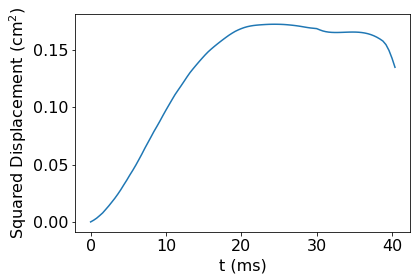

In [103]:
plt.plot(t_values,sd_values*DS**2)
format_plot(ax=plt.gca(),xlabel='t (ms)',ylabel=r'Squared Displacement (cm$^2$)',fontsize=16)

True

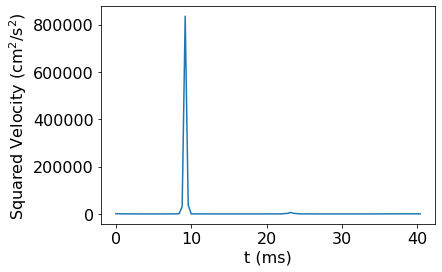

In [104]:
plt.plot(t_values,vsq_values)
format_plot(ax=plt.gca(),xlabel='t (ms)',ylabel=r'Squared Velocity (cm$^2$/s$^2$)',fontsize=16)

In [106]:
mean_lifetime=np.mean(lifetime_lst)

In [97]:
np.mean(v_rms_lst)

103.73975946970626

In [107]:
Delta_mean_lifetime=bootstrap_95CI_Delta_mean(x, num_samples=1000)

In [108]:
#TODO: fix v_rms
#TODO: aggregate over all annihilation events
#TODO: repeat for LR model

# TODO(later): measure period of oscillation 
- DONT: ~140ms and the parameters might be wrong - option A: for isolated spiral waves
- TODO: option B: for crowded spiral waves
        - option B.A:
        - HINT: try computing autocorrelation function of MSD, as for MSR, above...).
        - prerequisite, for each spiral pair involved in an annihilation, if it doesn't jump for x seconds, compute the MSD up until its first jump.
            - HINT: I think I have a function that does ^this somehwere...
            - TODO: check lib for this sd measurement function that works immediately.  If it doesn't work, just dev it here!
        - option B.B:
            - compare with some average measure of the period period,
            
$$
\hat{T}(t)=\frac{2\pi ||\vec{r}'(t)||^2}{||\vec{r}'(t)\times\vec{r}''(t)||}
$$

where the velocity and acceleration of the observed trajectory $\vec{r}(t)$ is computed using a Savitzky-Golay filtration.